# 回帰分析

## 始める前に

次のセルの１行目以外をアンコメント（`# `を削除）しなさい。アンコメントするには次の手順に従う。
* Windowsの場合：１行目以外の全ての行を選択し，`Ctrl`を押したまま`/`を押す。
* Macの場合：１行目以外の全ての行を選択し，`command`を押したまま`/`を押す。

In [ ]:
# CELL PROVIDED
# import piplite
# await piplite.install(['py4macro','japanize-matplotlib-jlite'])
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (4, 3)

次のコードを実行しなさい。

In [6]:
# CELL PROVIDED
import japanize_matplotlib_jlite
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

## 目的

* `Python`を使い回帰分析をおこなう方法を解説する
* オークンの法則について考察する

## オークンの法則

### 説明

この節で使用する記号：
* $Y_t$：GDP
* $\bar{Y}_t$：産出量の自然率水準（もしくは長期的GDP、潜在的GDP）
* $u_t$：失業率
* $\bar{u}_t$：自然失業率（もしくは長期的失業率）

オークンの法則は経験則として次の関係を表す。

$$
\frac{Y_t-\bar{Y}_t}{\bar{Y}_t}=-b\left( u_t-\bar{u}_t\right),\quad b>0
$$ (eq:11-okun)

左辺はGDPの自然率水準からの乖離率（％）であり，右辺は失業率の自然率からの乖離（％ポイント）である。

> 失業率の乖離が1%ポイント上昇するとGDPの乖離率は何%減少するのだろうか。

ここでは簡便的にHodrick–Prescottフィルターを使って計算したトレンドを$\bar{Y}$と$\bar{u}$とし，トレンドからの乖離を上の式の左辺と右辺に使う。

３つの変数`gdp`，`unemployment_rate`，`inflation`を読み込む。

In [8]:
cols = ['gdp','unemployment_rate','inflation']
df = py4macro.data('jpn-q').loc[:,cols]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1980-01-01 to 2023-10-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gdp                176 non-null    float64
 1   unemployment_rate  176 non-null    float64
 2   inflation          176 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB


### 失業率の特徴

まず図示してみよう。

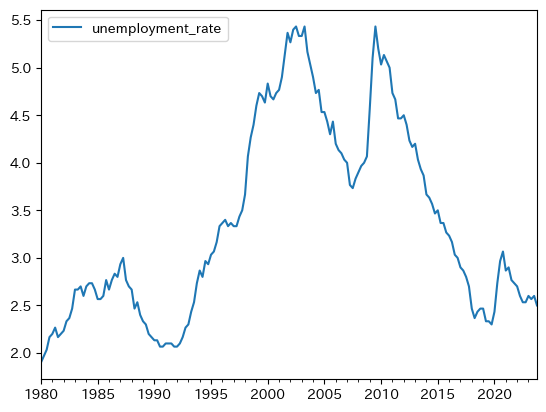

In [10]:
df.plot(y='unemployment_rate')
pass

持続性（persistence）が高い。メソッド`.autocorr()`を使い自己相関係数を計算すると非常に高い値が返される。

In [11]:
df.loc[:,'unemployment_rate'].autocorr()

0.9919383533843963

次に，GDPのトレンドからの乖離（％）と失業率のトレンドからの乖離（％ポイント）を比べてみる。

（注意）失業に関する変数を作成するが，対数を取らずに差分をトレンドからの乖離とする（％ポイント）。

In [12]:
df['u_rate_trend'] = py4macro.trend(df['unemployment_rate'])
df['u_rate_cycle'] = df['unemployment_rate'] - df['u_rate_trend']

ここで作成した変数は次の変数を表している。
* `unemployment_rate_cycle`：$u_t-\bar{u}_t$
* ％ポイント乖離

次にGDPのトレンドからの乖離率を計算しよう。
* `gdp_cycle`：$\dfrac{Y_t}{\bar{Y}_t}-1$
* ％乖離

In [13]:
df['gdp_cycle'] = 100*( 
    np.log(df['gdp']) - py4macro.trend( np.log(df['gdp']) )
)

GDPの乖離と重ねて動きを確認してみる。

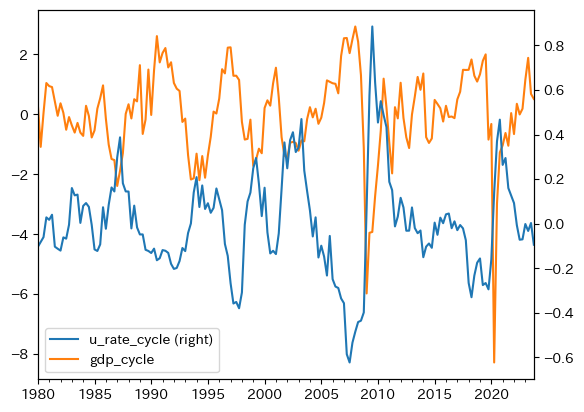

In [14]:
df.loc[:,['u_rate_cycle','gdp_cycle']].plot(secondary_y='u_rate_cycle')
pass

`df`のメソッド`corr()`を使い相関係数を計算しよう。

In [15]:
df.loc[:,['u_rate_cycle','gdp_cycle']].corr()

,u_rate_cycle,gdp_cycle
u_rate_cycle,1.000000,-0.625012
gdp_cycle,-0.625012,1.000000


右上と左下の値が２変数の相関係数 →　強い逆相関

また上の図から持続性が高いことが伺える。自己相関係数を計算してみよう。

In [16]:
df.loc[:,'gdp_cycle'].autocorr()

0.6974503788764267

In [17]:
df.loc[:,'u_rate_cycle'].autocorr()

0.8747098429841068

<Axes: xlabel='u_rate_cycle', ylabel='gdp_cycle'>

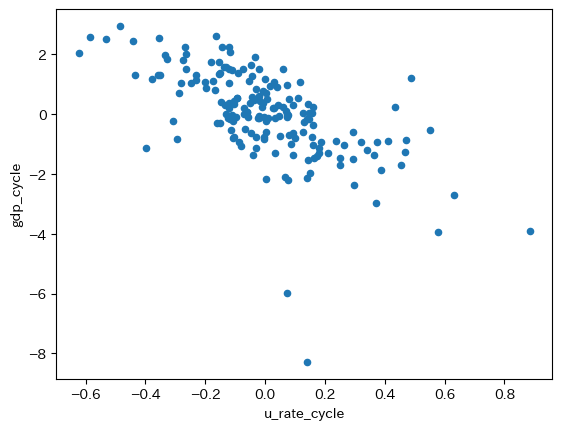

In [18]:
df.plot(x='u_rate_cycle', y='gdp_cycle', kind='scatter')

### 回帰分析

`statsmodels`を次の順番で使い方を説明する。
* `ols`サブパッケージを読み込む
* 回帰式を定義する
* 推定値の自動計算

**Step 1: サブパッケージの読み込み**

`statsmodels`を使い最も直感的な書き方を説明する。冒頭で次のコードでインポートされている。
```
import statsmodels.formula.api as smf
```
`smf`に含まれる関数`ols`を使い計算する。

**Step 2: 回帰式の定義**

* 式を`''`で囲む（文字列）
* 定数項は自動的に挿入される。

```
被説明変数 ~ 説明変数
```
`gdp_cycle`を被説明変数にし，定数項を加えて`u_rate_cycle`を説明変数をする場合，次のように書く。

In [19]:
formula = 'gdp_cycle ~ u_rate_cycle'

**Step 3: 自動計算**

* 自動計算の準備として計算の対象となるもの（インスタンス）を生成し、変数`mod`（"model"の省略形）に割り当てる。
* 第１引数は上で定義した回帰式，第２引数`data`は使用するデータをを指定する。

In [20]:
mod = smf.ols(formula, data=df)

`mod`の属性を調べてみよう。

In [21]:
py4macro.see(mod)

.data               .df_model           .df_resid           .endog
.endog_names        .exog               .exog_names         .fit
.fit_regularized    .formula            .from_formula       .get_distribution
.hessian            .hessian_factor     .information        .initialize
.k_constant         .loglike            .nobs               .pinv_wexog
.predict            .rank               .score              .weights
.wendog             .wexog              .whiten


* OLS関連の計算を一瞬で実行するメソッド`fit()`が準備されている。
* 結果を`res`に割り当てる（`res`はresultの略）。

In [22]:
res = mod.fit()

上の２つを分けずに一行で書いても良い。
```
res = smf.ols(formula, data=df).fit()
```
`res`の属性を確認してみよう。

In [24]:
py4macro.see(res)

.HC0_se             .HC1_se             .HC2_se             .HC3_se
.aic                .bic                .bse                .centered_tss
.compare_f_test     .compare_lm_test    .compare_lr_test    .condition_number
.conf_int           .conf_int_el        .cov_HC0            .cov_HC1
.cov_HC2            .cov_HC3            .cov_kwds           .cov_params
.cov_type           .df_model           .df_resid           .eigenvals
.el_test            .ess                .f_pvalue           .f_test
.fittedvalues       .fvalue             .get_influence      .get_prediction
.get_robustcov_results  .info_criteria      .initialize         .k_constant
.llf                .load               .model              .mse_model
.mse_resid          .mse_total          .nobs               .normalized_cov_params
.outlier_test       .params             .predict            .pvalues
.remove_data        .resid              .resid_pearson      .rsquared
.rsquared_adj       .save               .scale         

上のリストの中に`.params`とあるが，この属性を使い係数の推定値を取り出すことができる。

In [25]:
res.params

Intercept       2.427818e-11
u_rate_cycle   -4.060761e+00
dtype: float64

* メソッド`summary()`を使うと主な結果がまとめられた表を出力する。

In [26]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_cycle   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     111.5
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           1.84e-20
Time:                        16:27:47   Log-Likelihood:                -275.03
No. Observations:                 176   AIC:                             554.1
Df Residuals:                     174   BIC:                             560.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.428e-11      0.088   2.77e-10   

上の表は３つの表から構成されており，必要な部分だけを表示することも可能である。
```
res.summary().tables[0]
res.summary().tables[1]
res.summary().tables[2]
```
例えば，係数の推定値に関する基本的な統計量だけを表示するには以下のようにすれば良い。

In [27]:
print(res.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.428e-11      0.088   2.77e-10      1.000      -0.173       0.173
u_rate_cycle    -4.0608      0.384    -10.562      0.000      -4.820      -3.302


**＜表の説明＞**

表は3つのセクションから構成されている。
* 上段にはOLS推定の基本的な情報が表示されている。
    * 左側
        * `Dep. Variable`：被説明変数
        * `Model`：モデル
        * `Method`：手法
        * `Data`：日にち
        * `Time`：時間
        * `No. Observation`：標本の大きさ
        * `Df Residuals`：残差の自由度
        * `Df Model`：モデルの自由度（定数項以外の説明変数の数）
        * `Covariance Type`：共分散のタイプ
    * 右側
        * `R-squared`：決定係数
        * `adj. R-squared`：自由度調整済み決定係数
        * `F-statistic`：$F$統計量
        * `Prob (F-statistic)`：$F$値
        * `Log-Likelihood`：対数尤度
        * `AIC`：赤池情報量規準
        * `BIC`：ベイズ情報量規準
* 中段には主な推定結果が表示される。
    * 列ラベル
        * `coef`：係数
        * `std err`：標準誤差
        * `t`：$t$値
        * `P>|t|`：$p$値
        * `[0.025,0.975]`：信頼区間（5%)
    * 行ラベル
        * `Intercept`：定数項
        * `tfp_relative`：説明変数（選択する変数によって変わる）
* 下段には様々な検定などに関する数値が並んでいる。
    * 左側
        * `Omnibus`：オムニバス検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(Omnibus)`：オムニバス検定$p$値（帰無仮説：残差は正規分布に従う）
        * `Skew`：残差の歪度（正規分布であれば`0`）
        * `Kurtosis`：残差の尖度（正規分布であれば`3`）
    * 右側
        * `Durbin-Watson`：ダービン・ワトソン統計量（残差の自己相関の検定）
        * `Jarque-Bera (JB)`：ジャーク・ベラ検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(JB)`：ジャーク・ベラ検定$p$値（帰無仮説：残差は正規分布に従う）
        * `Cond. No.`：条件指数（Condition Index）の最大値（多重共線性を確認するための指標であり，単回帰分析では無視して良い。）

表の中段から次のことがわかる。
* 定数項の推定値は非常に小さい。さらにp値は大きく、通常の有意水準では「定数項の値はゼロ」の帰無仮説を棄却できない。
    * 上のオークンの法則の式と整合的
* パラメータ`b`の推定値は負の値となっていおり、`p`値の値は非常に低く通常の有意水準では$\hat{b}=0$の帰無仮説を棄却できない。

＜解釈＞
* 失業率が1％ポイント乖離すると，GDPはの約`-4.0`％乖離する。
* この値は非常に大きい。バブル崩壊時の乖離率は約`2.6`％，リーマン・ショック時では約`6`％，コロナ禍では`7.7`％である。これは日本の雇用制度を反映していると考えられる。

次に、標本の散布図に回帰直線を重ねて表示してみる。
* `result`の属性`.fittedvalues`を使い非説明変数の予測値を抽出
* `df`に`予測値`のラベルを使って新たな列として追加する。

`res`の主な属性とメソッド：
* `nobs`：標本の大きさ（Number of OBservationS）
* `params`：推定値（PARAMeterS）
* `bse`：推定値の標準誤差（Standard Errors）
* `tvalues`：推定値の$t$値（T VALUES）
* `pvalues`：推定値の$p$値（P VALUES）
* `rsquared`：決定係数（R SQUARED）
* `rsquared_adj`：自由度調整ずみ決定係数（ADJusted R SQUARED）
* `conf_int()`：95%信頼区間（CONFidence INTerval）
* `fittedvalues`：予測値（$\hat{y}$）（FITTED VALUES）
* `resid`：残差（$\hat{u}$）（RESIDuals）

In [28]:
res.tvalues

Intercept       2.773714e-10
u_rate_cycle   -1.056151e+01
dtype: float64

散布図のプロット

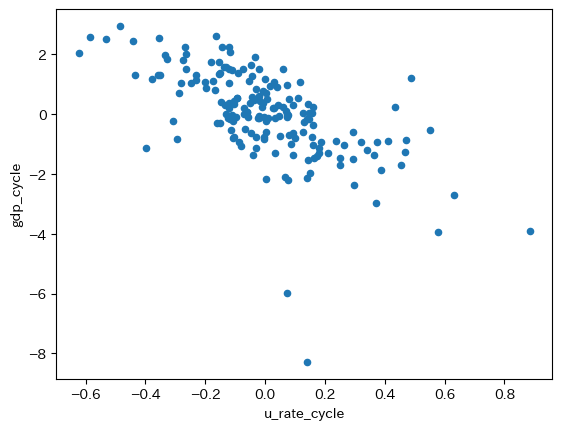

In [29]:
df.plot(x='u_rate_cycle',
        y='gdp_cycle',
        kind='scatter')
pass

回帰直線を重ねて表示する。

In [30]:
df.loc[:,'予測値'] = res.fittedvalues

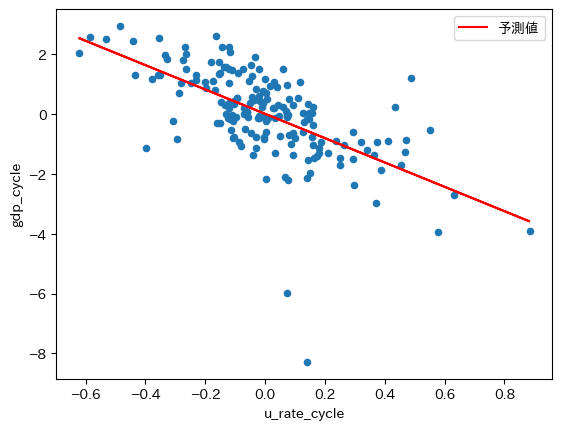

In [31]:
ax_ = df.plot(x='u_rate_cycle',
              y='gdp_cycle',
              kind='scatter')

df.plot(x='u_rate_cycle',
        y='予測値',
        kind='line',
        color='red',
        ax=ax_)
pass

決定係数の表示

In [32]:
res.rsquared

0.39064012719197705

調整済み決定係数

In [33]:
res.rsquared_adj

0.38713805895744813

残差のプロット

In [34]:
df.loc[:,'残差'] = res.resid

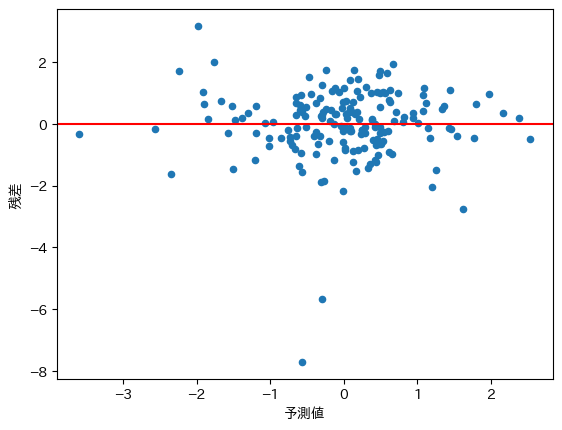

In [35]:
ax_ = df.plot(x='予測値', y='残差', kind='scatter')
ax_.axhline(0, color='red')

大きく外れている残差はいつのデータか調べてみよう。

In [36]:
df.sort_values('残差').head(3)

,gdp,unemployment_rate,inflation,u_rate_trend,u_rate_cycle,gdp_cycle,予測値,残差
,,,,,,,,
2020-04-01,502708.7,2.733333,-0.133333,2.593946,0.139387,-8.281962,-0.566017,-7.715945
2009-01-01,482048.7,4.566667,-0.033333,4.495020,0.071647,-5.977597,-0.290940,-5.686657
2008-10-01,506449.9,4.066667,1.033333,4.464765,-0.398098,-1.128021,1.616582,-2.744603
